# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLVU/HW2'

/content/drive/MyDrive/MLVU/HW2


## Module Import

In [3]:
!pip install xmltodict
!pip install opencv-python
!pip install tensorflow

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import xmltodict

import os
import glob
import math
import cv2

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import copy

In [ ]:
print(tf.__version__)

2.6.0


## [0] Data Loading

In [5]:
def read_images(images_list, first_index, last_index, image_height, image_width):
    images = []

    for i in range(first_index, last_index):

        im = cv2.imread(images_list[i])
        im = cv2.resize(im, (image_height, image_width))/255.

        images.append(im)

    return np.asarray(images)

In [6]:
def get_classes(xml_files):
    """
    Get the list of object class types using annotation

    Inputs: 
     - xml_files: dataset's annotations

    Returns: 
     - classes: list of class types 
    """
    classes = []
    
    for file in xml_files: 

        f = open(file)
        doc = xmltodict.parse(f.read()) 
        try:             
            for obj in doc['annotation']['object']:
                classes.append(obj['name'].lower()) 
        except TypeError as e: 
            classes.append(doc['annotation']['object']['name'].lower()) 
        f.close()

    classes = list(set(classes)) 
    classes.sort()

    return classes

In [7]:
def get_labels_from_data(xml_file, classes, num_of_class, image_height, image_width, image_depth):
    """
    Read 1 dataset and get class label and resized ground truth of box coordinates to match 224*224 images

    Inputs:
     - xml_file: 1 xml file
     - classes: list of class type
     - num_of_class: number of class types
     - image_height: height of image
     - image_width: width of image
     - image_depth: depth of image

    Returns: 
     - class_label: list of one hot encoded index for class label
     - box_label: array of ground truth box coordinates. Each box coordinates mean [x of top-left, y of top-left, x of bottom-right, y of bottom-right]
    """

    f = open(xml_file)
    doc = xmltodict.parse(f.read()) 


    ori_img_height = float(doc['annotation']['size']['height'])
    ori_img_width  = float(doc['annotation']['size']['width'])


    class_label = [] 
    box_label  = [] 

    try:
        for each_obj in doc['annotation']['object']:
            obj_class = each_obj['name'].lower() 

            x_min = float(each_obj['bndbox']['xmin']) 
            x_max = float(each_obj['bndbox']['xmax']) 
            y_min = float(each_obj['bndbox']['ymin']) 
            y_max = float(each_obj['bndbox']['ymax']) 

            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)

            generated_box_info = [x_min, y_max, x_max, y_min]   #top_left_x, top_left_y, btm_right_x, btm_right_y       
            index = classes.index(obj_class) 

            class_label.append(index)
            box_label.append(np.asarray(generated_box_info, dtype='float32'))

    except TypeError as e : 

        obj_class = doc['annotation']['object']['name']
        x_min = float(doc['annotation']['object']['bndbox']['xmin']) 
        x_max = float(doc['annotation']['object']['bndbox']['xmax']) 
        y_min = float(doc['annotation']['object']['bndbox']['ymin']) 
        y_max = float(doc['annotation']['object']['bndbox']['ymax']) 

        x_min = float((image_width/ori_img_width)*x_min)
        y_min = float((image_height/ori_img_height)*y_min)
        x_max = float((image_width/ori_img_width)*x_max)
        y_max = float((image_height/ori_img_height)*y_max)

        generated_box_info = [x_min, y_max, x_max, y_min]   #top_left_x, top_left_y, btm_right_x, btm_right_y

        index = classes.index(obj_class) 


        class_label.append(index)
        box_label.append(np.asarray(generated_box_info, dtype='float32'))


    return class_label, np.asarray(box_label)

## [1] Model

#### (0) [RPN] Anchor Generating

In [8]:
def generate_anchors(rpn_kernel_size, backbone_pooled_ratio, anchor_sizes, anchor_ratios, image_height, image_width, image_depth):
    list_of_anchors = []
    anchor_booleans = []
    
    starting_center = rpn_kernel_size//2
    anchor_center = [starting_center-1, starting_center]
    featuremap_height = image_height/backbone_pooled_ratio
    featuremap_width = image_width/backbone_pooled_ratio
    
    sizes = np.outer(anchor_sizes,anchor_ratios)

    while (anchor_center != [featuremap_width - (1+starting_center), featuremap_height - (1+starting_center)]):
        anchor_center[0] += 1
        
        if anchor_center[0] > featuremap_width - (1+starting_center):
            anchor_center[1] += 1
            anchor_center[0] = starting_center
            
        anchor_center_on_image = [anchor_center[0]*backbone_pooled_ratio, anchor_center[1]*backbone_pooled_ratio]
        
        ### 2 - (c) ###
        for i in range(3):
          for j in range(0,6,2):
            list_of_anchors.append(anchor_center_on_image + list(sizes[i,j:j+2]))
            if (anchor_center_on_image[0] + sizes[i,j:j+2][0]/2 > image_width) or (anchor_center_on_image[0] - sizes[i,j:j+2][0]/2 < 0) or (anchor_center_on_image[1] + sizes[i,j:j+2][1]/2 > image_height) or (anchor_center_on_image[1] - sizes[i,j:j+2][1]/2 < 0):
              anchor_booleans.append(0)
            else: 
              anchor_booleans.append(1)
        ### 2 - (c) ###
    #print(len(list_of_anchors))    
    return list_of_anchors, anchor_booleans
    

In [9]:
def generate_label(class_labels, ground_truth_boxes, anchors, anchor_booleans, num_of_class, neg_threshold, pos_threshold):
    """
    Label the anchors for training
    
    1) Calculate IoU between GT boxes and anchors
    2) Compare IoU with threshold values and classify the anchors
        a) IoU >= pos_threshold with at least 1 GT box -> Positive Anchor
        b) IoU < pos_threshold and IoU > neg_threshold with at least 1 GT box -> Ignore (Not use them for training)
        c) IoU <= neg_threshold -> Negative Anchor (Background)
    3) Label the Positive Anchors using matched GT box's information (Objectiveness and Box Coordinates)

    regression labels are generated as t_i form [t_x, t_y, t_w, t_h]
    
    """
    
    num_of_anchors = len(anchors)
    
    anchor_boolean_array = np.reshape(np.asarray(anchor_booleans), (num_of_anchors, 1))
    objectness_label_array = np.zeros((num_of_anchors, 2), dtype=np.float32) #2->obj./No obj.
    box_regression_array = np.zeros((num_of_anchors, 4), dtype=np.float32) #4->box coordinates(top-left_x, top-left_y, bottom-right_x, bottom-right_y)
    class_array = np.zeros((num_of_anchors, num_of_class), dtype=np.float32)
    
    for j in range(ground_truth_boxes.shape[0]):
        gt_box_top_left_x = ground_truth_boxes[j][0]
        gt_box_top_left_y = ground_truth_boxes[j][1]
        gt_box_btm_right_x = ground_truth_boxes[j][2]
        gt_box_btm_right_y = ground_truth_boxes[j][3]
        
        gt_box_area = (gt_box_btm_right_x - gt_box_top_left_x + 1)*(gt_box_top_left_y - gt_box_btm_right_y + 1)
        
        for i in range(num_of_anchors):
            if anchor_boolean_array[i][0] == 0:
                continue
                
            anchor = anchors[i]
            
            anchor_top_left_x = anchor[0] - anchor[2]/2
            anchor_top_left_y = anchor[1] + anchor[3]/2
            anchor_btm_right_x = anchor[0] + anchor[2]/2
            anchor_btm_right_y = anchor[1] - anchor[3]/2
            
            anchor_box_area = (anchor_btm_right_x - anchor_top_left_x + 1)*(anchor_top_left_y - anchor_btm_right_y + 1)
            
            int_rect_top_left_x = max(gt_box_top_left_x, anchor_top_left_x)
            int_rect_top_left_y = min(gt_box_top_left_y, anchor_top_left_y)
            int_rect_btm_right_x = min(gt_box_btm_right_x, anchor_btm_right_x)
            int_rect_btm_right_y = max(gt_box_btm_right_y, anchor_btm_right_y)

            int_rect_area = max(0, int_rect_btm_right_x - int_rect_top_left_x + 1) * max(0, int_rect_top_left_y - int_rect_btm_right_y + 1)

            intersect_over_union = float(int_rect_area / (gt_box_area + anchor_box_area - int_rect_area))

            if intersect_over_union >= pos_threshold:

                objectness_label_array[i][0] = 1.
                objectness_label_array[i][1] = 0.

                class_label = class_labels[j]
                class_array[i][int(class_label)] = 1.

                gt_box_center_x = (ground_truth_boxes[j][0] + ground_truth_boxes[j][2])/2
                gt_box_center_y = (ground_truth_boxes[j][1] + ground_truth_boxes[j][3])/2
                gt_box_width = ground_truth_boxes[j][2] - ground_truth_boxes[j][0]
                gt_box_height = ground_truth_boxes[j][1] - ground_truth_boxes[j][3]

                delta_x = (gt_box_center_x - anchor[0])/anchor[2]
                delta_y = (gt_box_center_y - anchor[1])/anchor[3]
                delta_w = math.log(gt_box_width/anchor[2])
                delta_h = math.log(gt_box_height/anchor[3])

                box_regression_array[i][0] = delta_x
                box_regression_array[i][1] = delta_y
                box_regression_array[i][2] = delta_w
                box_regression_array[i][3] = delta_h

            if intersect_over_union <= neg_threshold:
                if objectness_label_array[i][0] == 0:
                    
                    objectness_label_array[i][1] = 1.

            if intersect_over_union > neg_threshold and intersect_over_union < pos_threshold:
                if (objectness_label_array[i][0] == 0) and (objectness_label_array[i][1] == 0):
                    
                    anchor_boolean_array[i][0] = 0.


    return anchor_boolean_array, objectness_label_array, box_regression_array, class_array

In [10]:
def anchor_sampling(anchor_booleans, objectness_label, anchor_sampling_num):
    """
    Negative sample >> Positive sample
    
    So, make balance between them by limiting the number of negative anchors. (positive anchors, as well)
    
    """
    
    positive_count = 0
    negative_count = 0
    
    for i in range(objectness_label.shape[0]):
        if objectness_label[i][0] == 1:
            if positive_count > anchor_sampling_num:

                anchor_booleans[i][0] = 0.

            positive_count += 1

        if objectness_label[i][1] == 1:
            if negative_count > anchor_sampling_num:

                anchor_booleans[i][0] = 0.

            negative_count += 1

    return anchor_booleans

In [11]:
def generate_dataset_with_anchors(annotations_list, first_index, last_index, anchors, anchor_booleans, anchor_sampling_num, classes, num_of_class, neg_threshold, pos_threshold, image_height, image_width, image_depth):
    """
    Generate, Label, and Sample the anchors for training
    
    """
    
    num_of_anchors = len(anchors)
    
    batch_anchor_booleans = []
    batch_objectness_array = []
    batch_regression_array = []
    batch_class_label_array = []
    
    for i in range(first_index, last_index):

        true_labels, ground_truth_boxes = get_labels_from_data(annotations_list[i], classes, num_of_class, image_height, image_width, image_depth)

        anchor_bools, objectness_label_array, box_regression_array, class_array = generate_label(true_labels, ground_truth_boxes, anchors, anchor_booleans,num_of_class, neg_threshold, pos_threshold)
        
        anchor_bools = anchor_sampling(anchor_bools, objectness_label_array, anchor_sampling_num)
        
        batch_anchor_booleans.append(anchor_bools)
        batch_objectness_array.append(objectness_label_array)
        batch_regression_array.append(box_regression_array)
        batch_class_label_array.append(class_array)
    
    batch_anchor_booleans = np.reshape(np.asarray(batch_anchor_booleans), (-1, num_of_anchors))
    batch_objectness_array = np.asarray(batch_objectness_array)
    batch_regression_array = np.asarray(batch_regression_array)
    batch_class_label_array = np.asarray(batch_class_label_array)

    return (batch_anchor_booleans, batch_objectness_array, batch_regression_array, batch_class_label_array)

#### (1) Backbone CNN (VGGNet-16)

In [12]:
class Backbone_CNN(tf.keras.Model):
    """
    VGG-16 Network (until pool3 layer)
    
    conv1 : 3x3 Conv / # of filter : 64 / activation : ReLU / padding option : 'same'
    conv2 : 3x3 Conv / # of filter : 64 / activation : ReLU / padding option : 'same'
    pool1 : 2x2 Pool
    conv3 : 3x3 Conv / # of filter : 128 / activation : ReLU / padding option : 'same'
    conv4 : 3x3 Conv / # of filter : 128 / activation : ReLU / padding option : 'same'
    pool2 : 2x2 Pool
    conv5 : 3x3 Conv / # of filter : 256 / activation : ReLU / padding option : 'same'
    conv6 : 3x3 Conv / # of filter : 256 / activation : ReLU / padding option : 'same'
    conv7 : 3x3 Conv / # of filter : 256 / activation : ReLU / padding option : 'same'
    pool3 : 2x2 Pool
    
    
    input : Original Image (None, 224, 224, 3)
    Output : Feature Map (None, 28, 28, 256)
    
    """

    def __init__(self):
        super(Backbone_CNN, self).__init__()
        ### 2 - (b) ###
        self.conv1 = layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")
        self.conv2 = layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")
        self.pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2))
        self.conv3 = layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")
        self.conv4 = layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")
        self.pool2 = MaxPool2D(pool_size=(2,2),strides=(2,2))
        self.conv5 = layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu")
        self.conv6 = layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu")
        self.conv7 = layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu")
        self.pool3 = MaxPool2D(pool_size=(2,2),strides=(2,2))
        ### 2 - (b) ###
         
        
    def call(self, x, training=None):
        ### 2 - (b) ###
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        ### 2 - (b) ###
                
        return x

#### (2) RPN (Region Proposal Network)

In [13]:
class RPN(tf.keras.Model):
    """
    Region Proposal Network which consists of convolution layers
    
    rpn_conv : 3x3 Conv / # of filter : 512 / activation : ReLU / padding option : 'valid'
    
    obj_conv : 1x1 Conv / # of filter : 18(=9x2) / activation : None / padding option : 'same'
    bb_conv : 1x1 Conv / # of filter : 36(=9x4) / activation : None / padding option : 'same'
    
    
    Input : Feature Map (None, 28, 28, 256)
    Output : objectness array (None, 26, 26, 18) , bounding box regression array (None, 26, 26, 36)
    (*Reshaping will be processed later in the code)
    
    """
    
    def __init__(self):
        super(RPN, self).__init__()
        ### 2 - (b) ###
        self.rpn_conv = layers.Conv2D(filters=512,kernel_size=(3,3),padding="valid", activation="relu")
        self.obj_conv = layers.Conv2D(filters=18,kernel_size=(1,1),padding="same")
        self.bb_conv = layers.Conv2D(filters=36,kernel_size=(1,1),padding="same")
        ### 2 - (b) ###
        
    def call(self, x, training=None):
        ### 2 - (b) ###
        x = self.rpn_conv(x)
        obj = self.obj_conv(x)
        bb_reg = self.bb_conv(x)
        ### 2 - (b) ###
                
        return obj, bb_reg

## [2] Auxiliary Function

In [14]:
def recover_bboxes_coordinates(bboxes, anchors, image_height, image_width):
    bboxes_coordinates = []

    for i, bbox in enumerate(bboxes):
        tx, ty, tw, th = bbox
        
        anchor_center_x, anchor_center_y, anchor_w, anchor_h = anchors[i]

        box_center_x = tx*anchor_w + anchor_center_x
        box_center_y = ty*anchor_h + anchor_center_y
        box_w = math.exp(tw) * anchor_w
        box_h = math.exp(th) * anchor_h

        box_top_left_x = max(0, min(image_width, box_center_x - box_w/2))
        box_top_left_y = min(image_height, max(0, box_center_y + box_h/2))
        box_btm_right_x = min(image_width, max(0, box_center_x + box_w/2))
        box_btm_right_y = max(0, min(image_height, box_center_y - box_h/2))
        
        bboxes_coordinates.append([box_top_left_x, box_top_left_y, box_btm_right_x, box_btm_right_y])
        
    return bboxes_coordinates

In [15]:
def NMS(obj_pred, bboxes_coordinates, num_of_anchors, num_of_bboxes, image_size, IoU_threshold=0.7):
    """
    Non Maximum Suppression module to extract most useful bounding boxes
    
    1) Sort the bounding boxes by their objectness score as descending order (**Apply softmax function to the input 'obj_pred')
    2) Choose the first one (say "B0") in the sorted list (say "L0").
        a) Pop "B0" from "L0" and append it to the output 'bboxes'
        b) Compare it with the others. Calculate IoU between two.
        c) If IoU > IoU_threshold -> pop the box compared with "B0" from "L0"
    3) Repeat 2) till "L0" becomes empty
    
    Output: bboxes (None, num_of_selected_bboxes, 4) ; coordinates of selected bboxes
  
    """
    obj_pred =  tf.nn.softmax(obj_pred)
    #List of bbox_cordinates sorted by score in obj_pred
    L0 =  tf.gather(bboxes_coordinates,tf.nn.top_k(obj_pred[:,0],k=num_of_anchors).indices)
    L0 =  list(L0.numpy())
    bboxes= []
    while L0:
        B0 = L0.pop(0)
        bboxes.append(B0)
        chosen_top_left_x =B0[0]
        chosen_top_left_y = B0[1]
        chosen_btm_right_x = B0[2]
        chosen_btm_right_y = B0[3]
        
        chosen_box_area = (chosen_btm_right_x - chosen_top_left_x + 1)*(chosen_top_left_y - chosen_btm_right_y + 1)


        L0_copy = copy.deepcopy(L0)
        popped_counter = 0
        for i in range(len(L0)):
            comparer = L0_copy[i]
            comparer_top_left_x =comparer[0]
            comparer_top_left_y = comparer[1]
            comparer_btm_right_x = comparer[2]
            comparer_btm_right_y = comparer[3]

            comparer_box_area = (comparer_btm_right_x - comparer_top_left_x + 1)*(comparer_top_left_y - comparer_btm_right_y + 1)



            int_rect_top_left_x = max(chosen_top_left_x,comparer_top_left_x )
            int_rect_top_left_y = min(chosen_top_left_y,comparer_top_left_y)
            int_rect_btm_right_x = min(chosen_btm_right_x, comparer_btm_right_x)
            int_rect_btm_right_y = max(chosen_btm_right_y, comparer_btm_right_y)

            int_rect_area = max(0, int_rect_btm_right_x - int_rect_top_left_x + 1) * max(0, int_rect_top_left_y - int_rect_btm_right_y + 1)

            intersect_over_union = float(int_rect_area / (comparer_box_area + chosen_box_area - int_rect_area))

            if intersect_over_union > IoU_threshold:
              L0.pop(i-popped_counter)
              popped_counter += 1


    ### 2 - (e) ###
    #bboxes = None ## (None, num_of_selected_bboxes, 4)
    ### 2 - (e) ###
    
                
    return bboxes


In [16]:
def smooth_func(t, num_of_anchors):
  
    t = tf.abs(t)

    comparison_tensor = tf.ones((num_of_anchors, 4))
    smoothed = tf.where(tf.less(t, comparison_tensor), 0.5*tf.pow(t,2), t-0.5)

    return smoothed

In [17]:
def smooth_L1(pred_box, truth_box, num_of_anchors):

    diff = pred_box - truth_box

    smoothed = smooth_func(diff, num_of_anchors)

    return smoothed

## [3] Training

In [18]:
def rpn_train_step(rpn_model, X, Y_obj, Y_coor, anchor_booleans, num_of_anchors, anchor_sampling_num, learning_rate, decay_steps, decay_rate):

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate, staircase=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    batch_size = X.shape[0]
    with tf.GradientTape() as tape:
        y1, y2 = rpn_model(X)

        y1 = tf.reshape(y1, (-1, num_of_anchors, 2))
        y2 = tf.reshape(y2, (-1, num_of_anchors, 4))

        lambda_value = 0.5

        ### 2 - (d) ###
        obj_loss = 1/(2*anchor_sampling_num*batch_size) * tf.math.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(Y_obj, y1)*anchor_booleans)
        reg_loss =  lambda_value/(anchor_sampling_num*batch_size) * tf.math.reduce_sum(anchor_booleans*Y_obj[:,:,0]*tf.math.reduce_sum(smooth_L1(y2,Y_coor,num_of_anchors),axis=2))
        total_loss = obj_loss + reg_loss
        ### 2 - (d) ###

    gradients = tape.gradient(total_loss, rpn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rpn_model.trainable_variables))

    return total_loss

## [4] Main

In [19]:
#Defining variables
image_size = 224
image_height = image_size
image_width  = image_size
image_depth  = 3      


pretrained_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
_backbone_cnn = tf.keras.models.Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)
# _backbone_cnn = Backbone_CNN()
_rpn = RPN()

_input = tf.keras.layers.Input(shape=(image_width,image_height,image_depth))
_output = _rpn(_backbone_cnn(_input))

rpn_model = tf.keras.Model(inputs=_input, outputs=_output)

In [20]:
def main_rpn():

    data_images_path     = 'VOCdevkit/VOC2007/JPEGImages'
    data_annotation_path = 'VOCdevkit/VOC2007/Annotations'
    
    image_size = 224
    image_height = image_size
    image_width  = image_size
    image_depth  = 3      


    images_list = sorted([x for x in glob.glob(data_images_path + '/**')])    
    total_images = len(images_list)
    annotations_list = sorted([x for x in glob.glob(data_annotation_path + '/**')]) 

    classes = get_classes(annotations_list)
    num_of_class = len(classes)

    
    featuremap_size = 28
    rpn_kernel_size = 3
    backbone_pooled_ratio = image_size/featuremap_size
    anchor_sizes = [32,64,128]
    anchor_ratios = [[1,1],[1/math.sqrt(2),math.sqrt(2)],[math.sqrt(2),1/math.sqrt(2)]]
    num_anchors_in_box = len(anchor_sizes)*len(anchor_ratios)
    anchor_sampling_num = 128

    anchors, an_bools = generate_anchors(rpn_kernel_size, backbone_pooled_ratio, anchor_sizes, anchor_ratios, image_height, image_width, image_depth)
    num_of_anchors = len(anchors)


    neg_threshold = 0.3
    pos_threshold = 0.7

    learning_rate = 1e-3
    num_epochs = 2
    batch_size = 50
    decay_steps = 10000
    decay_rate = 0.99


    train_loss = tf.keras.metrics.Mean(name='train_loss')

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        for start_idx in range(0, total_images, batch_size):
            end_idx = min(start_idx + batch_size, total_images-1)

            images = read_images(images_list, start_idx, end_idx, image_height, image_width)

            batch_anchor_booleans, batch_objectness_array, batch_regression_array, _ = \
            generate_dataset_with_anchors(annotations_list, start_idx, end_idx, anchors, an_bools, anchor_sampling_num, classes, num_of_class, neg_threshold, pos_threshold, image_height, image_width, image_depth)

            loss = rpn_train_step(rpn_model, images, batch_objectness_array, batch_regression_array, batch_anchor_booleans, num_of_anchors, anchor_sampling_num, learning_rate, decay_steps, decay_rate)
            train_loss(loss)

            if (start_idx//batch_size) % 10 == 0:
                print("\tProgress {:.0%} / Loss: {}".format(start_idx/total_images, train_loss.result()))

        print("Epoch: {}, Loss: {}".format(epoch+1, train_loss.result()))

        train_loss.reset_states()     

In [21]:
main_rpn()

Epoch 1/2
	Progress 0% / Loss: 4.764634132385254
	Progress 10% / Loss: 0.5945441126823425
	Progress 20% / Loss: 0.34337377548217773
	Progress 30% / Loss: 0.2424408197402954
	Progress 40% / Loss: 0.18860866129398346
	Progress 50% / Loss: 0.15491092205047607
	Progress 60% / Loss: 0.13174067437648773
	Progress 70% / Loss: 0.11491759121417999
	Progress 80% / Loss: 0.10271163284778595
	Progress 90% / Loss: 0.09316743910312653
	Progress 100% / Loss: 0.08528828620910645
Epoch: 1, Loss: 0.08528828620910645
Epoch 2/2
	Progress 0% / Loss: 0.006426455453038216
	Progress 10% / Loss: 0.011624190025031567
	Progress 20% / Loss: 0.011655413545668125
	Progress 30% / Loss: 0.013413512147963047
	Progress 40% / Loss: 0.013640162535011768
	Progress 50% / Loss: 0.013901665806770325
	Progress 60% / Loss: 0.01428395789116621
	Progress 70% / Loss: 0.014055140316486359
	Progress 80% / Loss: 0.013532550074160099
	Progress 90% / Loss: 0.013200378976762295
	Progress 100% / Loss: 0.012617155909538269
Epoch: 2, Loss

In [22]:
ckpt_dir = './model_ckpt/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
root = tf.train.Checkpoint(model=rpn_model)
root.save(ckpt_prefix)

'./model_ckpt/ckpt-1'

## [5] Print Sample Result

#### Print Original Data

In [23]:
data_images_path     = 'VOCdevkit/VOC2007/JPEGImages'
data_annotation_path = 'VOCdevkit/VOC2007/Annotations'

image_size = 224
image_height = image_size
image_width  = image_size
image_depth  = 3      


images_list = sorted([x for x in glob.glob(data_images_path + '/**')])    
total_images = len(images_list)
annotations_list = sorted([x for x in glob.glob(data_annotation_path + '/**')]) 

classes = get_classes(annotations_list)
num_of_class = len(classes)


featuremap_size = 28
rpn_kernel_size = 3
backbone_pooled_ratio = image_size/featuremap_size
anchor_sizes = [32,64,128]
anchor_ratios = [[1,1],[1/math.sqrt(2),math.sqrt(2)],[math.sqrt(2),1/math.sqrt(2)]]
num_anchors_in_box = len(anchor_sizes)*len(anchor_ratios)
anchor_sampling_num = 128

anchors, an_bools = generate_anchors(rpn_kernel_size, backbone_pooled_ratio, anchor_sizes, anchor_ratios, image_height, image_width, image_depth)
num_of_anchors = len(anchors)


neg_threshold = 0.3
pos_threshold = 0.7

In [24]:
idx = 3000
sample = read_images(images_list, idx, idx+1, image_height, image_width)
true_labels, ground_truth_boxes = get_labels_from_data(annotations_list[idx], classes, num_of_class, image_height, image_width, image_depth)

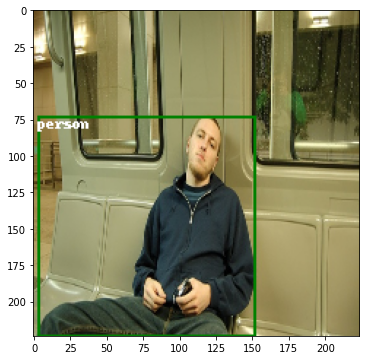

In [25]:
sample_image = Image.fromarray(((sample[0][:,:,[2,1,0]])*255).astype(np.uint8))
draw = ImageDraw.Draw(sample_image)

for i in range(len(true_labels)):
    name = classes[true_labels[i]]
    xmin, ymax, xmax, ymin = ground_truth_boxes[i]
    
    draw.rectangle(((xmin, ymin), (xmax, ymax)), outline='green', width=2)
    draw.text((xmin, ymin), name)
    
plt.figure(figsize=(8,6))
plt.imshow(sample_image)

#### Print Trained Result of RPN (after NMS)

In [26]:
obj, coor = rpn_model(sample)

obj = np.reshape(obj, (-1, 2))
coor = np.reshape(coor, (-1, 4))

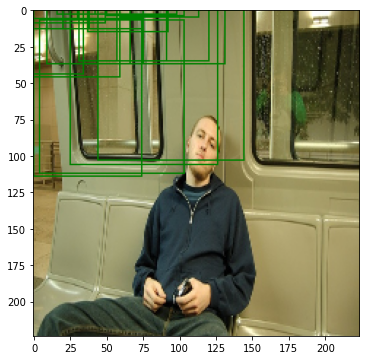

In [42]:
### 2 - (e) ###
# Abnormal result shouldn't be printed below
### 2 - (e) ###

num_of_bboxes = 20

sample_image = Image.fromarray(((sample[0][:,:,[2,1,0]])*255).astype(np.uint8))
draw = ImageDraw.Draw(sample_image)

starting_anchor_center = rpn_kernel_size//2

bboxes_coordinates = recover_bboxes_coordinates(coor, anchors, image_height, image_width)
bboxes = NMS(obj, bboxes_coordinates, num_of_anchors, num_of_bboxes, image_size)

for i in range(num_of_bboxes):
    draw.rectangle(((bboxes[i][0], bboxes[i][3]), (bboxes[i][2], bboxes[i][1])), outline='green', width=1)
    
plt.figure(figsize=(8,6))
plt.imshow(sample_image)

## [6] (Bonus) RoI Pooling

In [43]:
# Below code is taken and modifyed to this specific code from: https://medium.com/xplore-ai/implementing-attention-in-tensorflow-keras-using-roi-pooling-992508b6592b
class RoIPoolingLayer(tf.keras.layers.Layer):
    """
    Input: [featuremap, bboxes] [(None, 28, 28, 256), (None, # of bboxes, 4)]
    Output: RoI pooled result (None, # of bboxes, 2, 2, 256) -> Applied RoIPooling to each channel of featuremap
    
    """
    
    def __init__(self, roi_pooled_height, roi_pooled_width):
        self.pooled_height = roi_pooled_height
        self.pooled_width = roi_pooled_width
        
        super(RoIPoolingLayer, self).__init__()

    

    def call(self, x):
        """ Maps the input tensor of the ROI layer to its output
        
            # Parameters
                x[0] -- Convolutional feature map tensor,
                        shape (batch_size, pooled_height, pooled_width, n_channels)
                x[1] -- Tensor of region of interests from candidate bounding boxes,
                        shape (batch_size, num_rois, 4)
                        Each region of interest is defined by four relative 
                        coordinates (x_min, y_min, x_max, y_max) between 0 and 1
            # Output
                pooled_areas -- Tensor with the pooled region of interest, shape
                    (batch_size, num_rois, pooled_height, pooled_width, n_channels)
        """
        def curried_pool_rois(x): 
          return RoIPoolingLayer._pool_rois(x[0], x[1], 
                                            self.pooled_height, 
                                            self.pooled_width)
        
        pooled_areas = tf.map_fn(curried_pool_rois, x, dtype=tf.float32)

        return pooled_areas
    
    @staticmethod
    def _pool_rois(feature_map, rois, pooled_height, pooled_width):
        """ Applies ROI pooling for a single image and varios ROIs
        """
        def curried_pool_roi(roi): 
          return RoIPoolingLayer._pool_roi(feature_map, roi, 
                                           pooled_height, pooled_width)
        
        pooled_areas = tf.map_fn(curried_pool_roi, rois, dtype=tf.float32)
        return pooled_areas
    
    @staticmethod
    def _pool_roi(feature_map, roi, pooled_height, pooled_width):
        """ Applies ROI pooling to a single image and a single region of interest
        """

        # Compute the region of interest        
        feature_map_height = int(feature_map.shape[0])
        feature_map_width  = int(feature_map.shape[1])
        
        h_start = tf.cast(feature_map_height * roi[0], 'int32')
        w_start = tf.cast(feature_map_width  * roi[1], 'int32')
        h_end   = tf.cast(feature_map_height * roi[2], 'int32')
        w_end   = tf.cast(feature_map_width  * roi[3], 'int32')
        
        region = feature_map[h_start:h_end, w_start:w_end, :]
        
        # Divide the region into non overlapping areas
        region_height = h_end - h_start
        region_width  = w_end - w_start
        h_step = tf.cast( region_height / pooled_height, 'int32')
        w_step = tf.cast( region_width  / pooled_width , 'int32')
        
        areas = [[(
                    i*h_step, 
                    j*w_step, 
                    (i+1)*h_step if i+1 < pooled_height else region_height, 
                    (j+1)*w_step if j+1 < pooled_width else region_width
                   ) 
                   for j in range(pooled_width)] 
                  for i in range(pooled_height)]
        
        # take the maximum of each area and stack the result
        def pool_area(x): 
          return tf.math.reduce_max(region[x[0]:x[2], x[1]:x[3], :], axis=[0,1])
        
        pooled_features = tf.stack([[pool_area(x) for x in row] for row in areas])
        return pooled_features
    

        return x

In [44]:
### (Bonus) 2 - (f) ###
# Below code should be operated properly
# bboxes -> Use the NMS result of section [5] 
### (Bonus) 2 - (f) ###

#Rescaling bboxes
bboxes_s = list(np.asarray(bboxes)/image_size)

fast_rcnn_backbone_cnn_pretrained_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
fast_rcnn_backbone_cnn = tf.keras.models.Model(inputs=fast_rcnn_backbone_cnn_pretrained_model.input, outputs=fast_rcnn_backbone_cnn_pretrained_model.get_layer('block3_pool').output)

feature_map = fast_rcnn_backbone_cnn(sample)
bboxes_ = np.expand_dims(bboxes_s, 0)

RoIPooling = RoIPoolingLayer(roi_pooled_width=2, roi_pooled_height=2)
roi_pooled_result = RoIPooling([feature_map, bboxes_])